In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import torchvision
import torchvision.transforms as transforms
import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
from utils import *
import copy

%load_ext autoreload 
%autoreload 2

## load data

### 1.No augmentation

In [3]:
train_data, test_data,trainset,testset = dataloading(mean=[0.4914, 0.4822, 0.4465], 
                                        std=[0.2675, 0.2565, 0.2761], 
                                        dataset='CIFAR100',
                                        batch_size=256,
                                        num_workers=2,aug=False)

print("The Number of Samples in Train Set is :",len(trainset))
print("The Number of Samples in Test Set is :",len(testset))

The Number of Samples in Train Set is : 50000
The Number of Samples in Test Set is : 10000


### 2.Have augmentation

In [4]:
train_data, test_data,trainset,testset = dataloading(mean=[0.4914, 0.4822, 0.4465], 
                                        std=[0.2675, 0.2565, 0.2761], 
                                        dataset='CIFAR100',
                                        batch_size=256,
                                        num_workers=2,aug=True)

print("The Number of Samples in Train Set is :",len(trainset))
print("The Number of Samples in Test Set is :",len(testset))

The Number of Samples in Train Set is : 50000
The Number of Samples in Test Set is : 10000


## Baseline

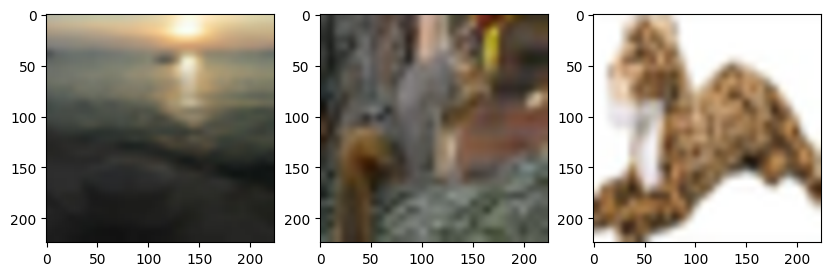

In [5]:
from torchvision.transforms.functional import InterpolationMode


transform = transforms.Compose([
            transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
            transforms.ToTensor()
        ])

train_image = datasets.CIFAR100(root='./data', train=True, download=False, transform=transform)
train_loader = DataLoader(train_image, batch_size=64, shuffle=False, num_workers=4)
ToPIL = transforms.ToPILImage()
a=1
for X, y in train_loader:
    for i in [14,18,28]:
        img = X[i]
        pic = ToPIL(img)
        pic.save('baseline' + str(i) + '.png')
        plt.subplot(1,3,a)
        plt.imshow(pic)
        a=a+1        
    break

plt.gcf().set_size_inches(10, 4)

Baseline Acc on test set: 0.597


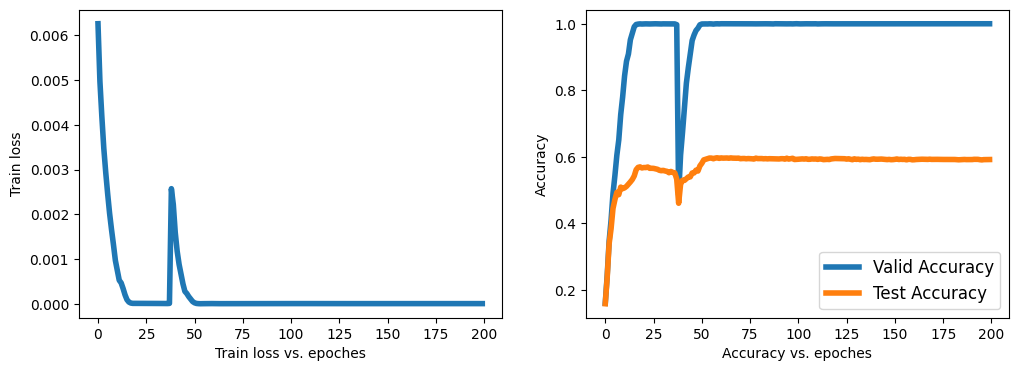

In [6]:
baseline_data = torch.load('./datas/baseline.pth')
loss_baseline, val_acc_baseline, test_acc_baseline = baseline_data['loss'],baseline_data['valid_acc'],baseline_data['test_acc']
print('Baseline Acc on test set:',max(test_acc_baseline))
x = range(200)
y1 = loss_baseline
z1 = val_acc_baseline
w1 = test_acc_baseline
plt.subplot(1,2,1)
plt.plot(x,y1,linewidth=4.0)
plt.xlabel('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.subplot(1,2,2)
plt.plot(x,z1,linewidth=4.0)
plt.plot(x,w1,linewidth=4.0)
plt.xlabel('Accuracy vs. epoches')
plt.ylabel('Accuracy')
plt.legend(['Valid Accuracy','Test Accuracy'],fontsize=12)
plt.gcf().set_size_inches(12, 4)
plt.show()

## Data augmentation

Acc on test set with Data Augumentation: 0.7136


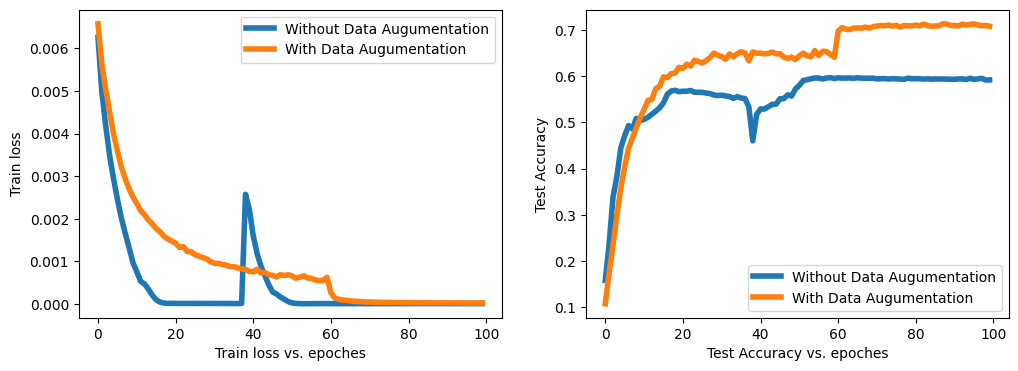

In [7]:
aug = torch.load('./datas/baseline_aug_data.pth')
loss_aug, val_acc_aug, test_acc_aug = aug['loss'],aug['valid_acc'],aug['test_acc']
loss_baseline, val_acc_baseline, test_acc_baseline =loss_baseline[:100], val_acc_baseline[:100], test_acc_baseline[:100]
print('Acc on test set with Data Augumentation:',max(test_acc_aug))
x = range(100)
y1 = loss_baseline
y2 = loss_aug
z1 = val_acc_baseline
z2 = val_acc_aug
w1 = test_acc_baseline
w2 = test_acc_aug
plt.subplot(1,2,1)
plt.plot(x,y1,linewidth=4.0)
plt.plot(x,y2,linewidth=4.0)
plt.xlabel('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.legend(['Without Data Augumentation','With Data Augumentation'])
plt.subplot(1,2,2)
plt.plot(x,w1,linewidth=4.0)
plt.plot(x,w2,linewidth=4.0)
plt.xlabel('Test Accuracy vs. epoches')
plt.ylabel('Test Accuracy')
plt.legend(['Without Data Augumentation','With Data Augumentation'])

plt.gcf().set_size_inches(12, 4)
plt.show()

## Cut out

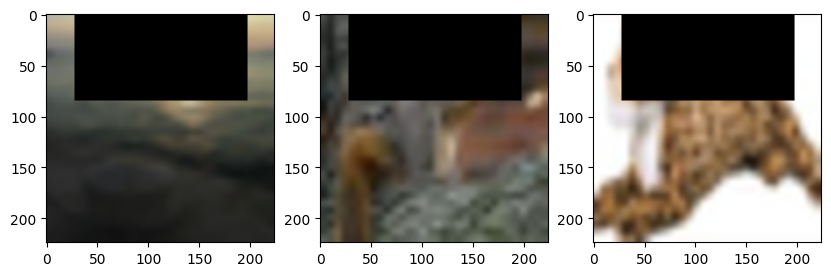

In [8]:
a=1
for X, y in train_loader:
    X = copy.deepcopy(X)
    lam = np.random.beta(0.5, 0.5)
    bbx1, bby1, bbx2, bby2 = rand_bbox(X.size(), lam)
    X[:, :, bbx1:bbx2, bby1:bby2] = 0.0
    for i in [14,18,28]:
        img = X[i]
        pic = ToPIL(img)
        pic.save('cutout' + str(i) + '.png')
        plt.subplot(1,3,a)
        plt.imshow(pic)
        a=a+1      
    break

plt.gcf().set_size_inches(10, 4)

Acc on test set with cutout: 0.7059


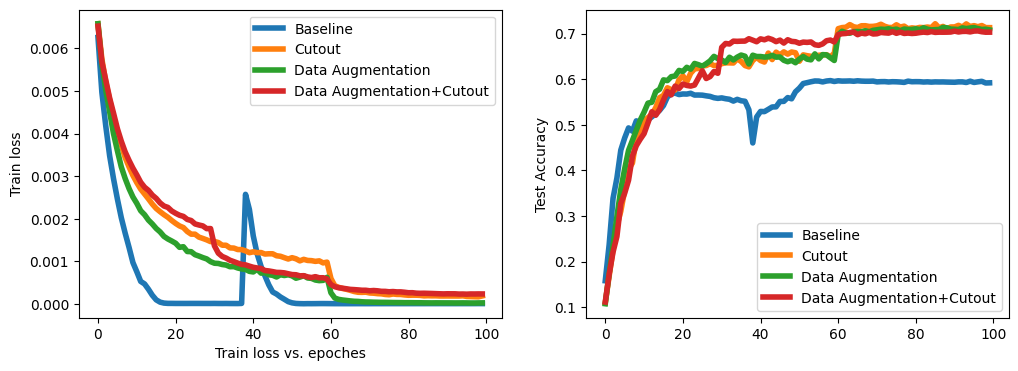

In [9]:
baseline_cutoutonly=torch.load('./datas/cutout_only.pth')
loss_cutoutonly, valid_acc_cutoutonly, test_acc_cutoutonly = baseline_cutoutonly["loss"],baseline_cutoutonly["valid_acc"],baseline_cutoutonly["test_acc"]
baseline_cutout=torch.load('./datas/cutout_aug.pth')
loss_cutout, val_acc_cutout, test_acc_cutout = baseline_cutout["loss"],baseline_cutout["valid_acc"],baseline_cutout["test_acc"]
print("Acc on test set with cutout:",max(test_acc_cutout))
x = range(100)
y1 = loss_baseline
y2 = loss_cutoutonly
y3 = loss_aug
y4 = loss_cutout
w1 = test_acc_baseline
w2 = test_acc_cutoutonly
w3 = test_acc_aug
w4 = test_acc_cutout
plt.subplot(1,2,1)
plt.plot(x,y1,linewidth=4.0)
plt.plot(x,y2,linewidth=4.0)
plt.plot(x,y3,linewidth=4.0)
plt.plot(x,y4,linewidth=4.0)

plt.xlabel('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.legend(['Baseline','Cutout','Data Augmentation','Data Augmentation+Cutout'])

plt.subplot(1,2,2)
plt.plot(x,w1,linewidth=4.0)
plt.plot(x,w2,linewidth=4.0)
plt.plot(x,w3,linewidth=4.0)
plt.plot(x,w4,linewidth=4.0)
plt.ylabel('Test Accuracy')
plt.legend(['Test Accuracy','Valid Accuracy'])
plt.legend(['Baseline','Cutout','Data Augmentation','Data Augmentation+Cutout'])

plt.gcf().set_size_inches(12, 4)
plt.show()

### Mixup

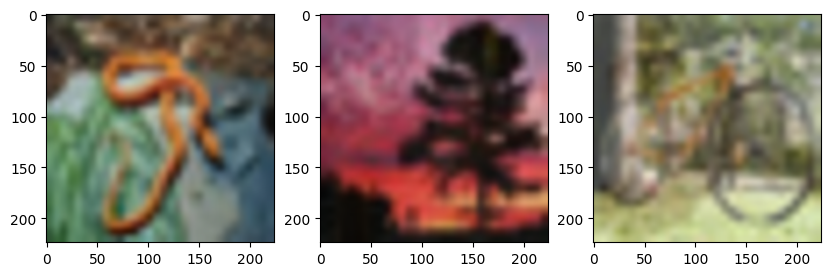

In [10]:
a=1
for X, y in train_loader:
    X = copy.deepcopy(X)
    lam = np.random.beta(1, 1)
    rand_index = torch.randperm(X.size()[0])
    X = X * lam + X[rand_index] * (1. - lam)
    for i in [14,18,28]:
        img = X[i]
        pic = ToPIL(img)
        pic.save('mixup' + str(i) + '.png')
        plt.subplot(1,3,a)
        plt.imshow(pic)
        a=a+1    
    break

plt.gcf().set_size_inches(10, 4)

Acc on test set with Mixup: 0.7541


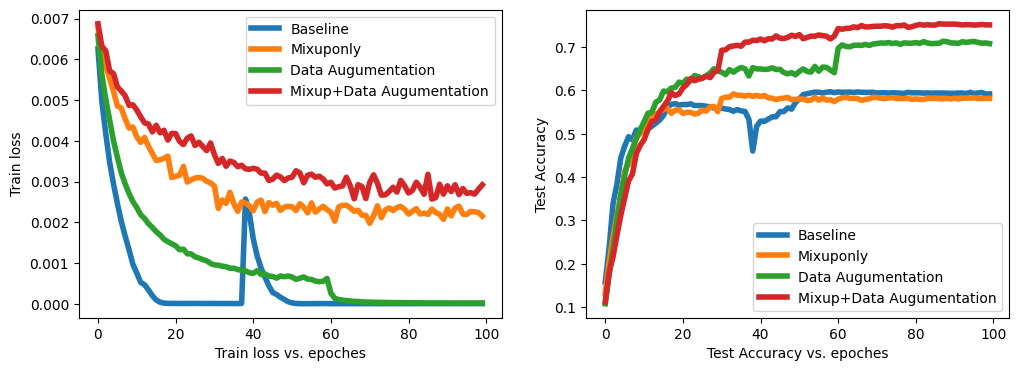

In [11]:
baseline_mixuponly=torch.load('./datas/mixup_only.pth')
loss_mixuponly, val_acc_mixuponly, test_acc_mixuponly= baseline_mixuponly["loss"],baseline_mixuponly["valid_acc"],baseline_mixuponly["test_acc"]
baseline_mixup=torch.load('./datas/mixup_aug.pth')
loss_mixup, val_acc_mixup, test_acc_mixup = baseline_mixup["loss"],baseline_mixup["valid_acc"],baseline_mixup["test_acc"]
print('Acc on test set with Mixup:',max(test_acc_mixup))
x = range(100)
y1 = loss_baseline
y2 = loss_mixuponly
y3 = loss_mixup
y4 = loss_aug
w1 = test_acc_baseline
w2 = test_acc_mixuponly
w3 = test_acc_mixup
w4 = test_acc_aug
plt.subplot(1,2,1)
plt.plot(x,y1,linewidth=4.0)
plt.plot(x,y2,linewidth=4.0)
plt.plot(x,y4,linewidth=4.0)
plt.plot(x,y3,linewidth=4.0)
plt.xlabel('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.legend(['Baseline','Mixuponly','Data Augumentation','Mixup+Data Augumentation'])
plt.subplot(1,2,2)
plt.plot(x,w1,linewidth=4.0)
plt.plot(x,w2,linewidth=4.0)
plt.plot(x,w4,linewidth=4.0)
plt.plot(x,w3,linewidth=4.0)
plt.xlabel('Test Accuracy vs. epoches')
plt.ylabel('Test Accuracy')
plt.legend(['Baseline','Mixuponly','Data Augumentation','Mixup+Data Augumentation'])
plt.gcf().set_size_inches(12, 4)
plt.show()

## Cutmix

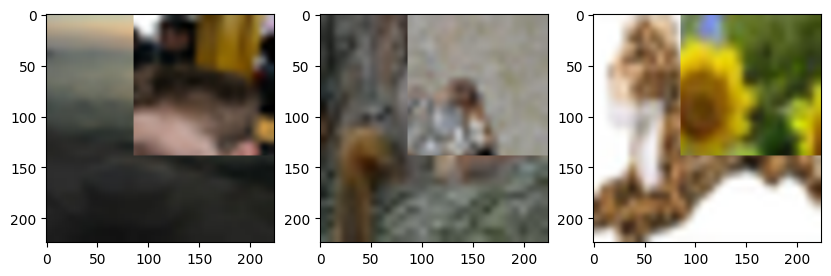

In [12]:
a=1
for X, y in train_loader:
    X = copy.deepcopy(X)
    lam = np.random.beta(1, 1)
    rand_index = torch.randperm(X.size()[0])
    bbx1, bby1, bbx2, bby2 = rand_bbox(X.size(), lam)
    X[:, :, bbx1:bbx2, bby1:bby2] = X[rand_index, :, bbx1:bbx2, bby1:bby2]
    for i in [14,18,28]:
        img = X[i]
        pic = ToPIL(img)
        pic.save('cutmix' + str(i) + '.png') 
        plt.subplot(1,3,a)
        plt.imshow(pic)
        a=a+1  
    break
    
plt.gcf().set_size_inches(10, 4)

Acc on test set with cutmix: 0.7174


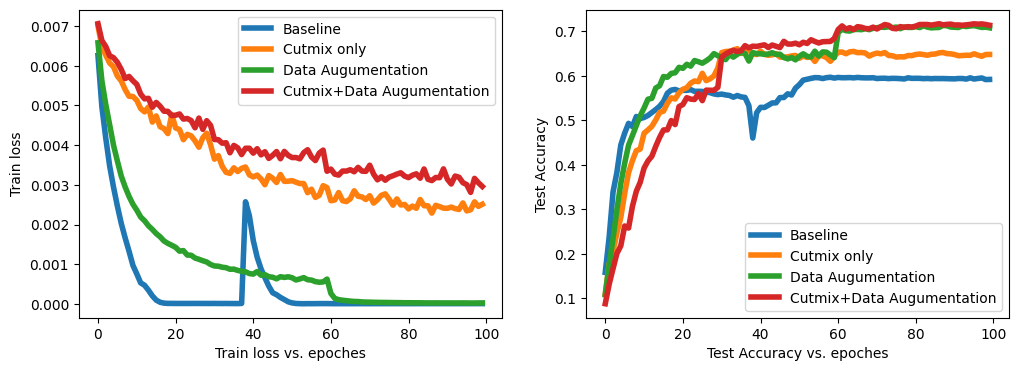

In [13]:
cutmixonly=torch.load('./datas/cutmix_only.pth')
loss_cutmixonly, val_cutmixonly, test_acc_cutmixonly= cutmixonly["loss"],cutmixonly["valid_acc"],cutmixonly["test_acc"]
cutmix=torch.load('./datas/cutmix_aug.pth')
loss_cutmix, val_cutmix, test_acc_cutmix= cutmix["loss"],cutmix["valid_acc"],cutmix["test_acc"]
print("Acc on test set with cutmix:",max(test_acc_cutmix))
x = range(100)
y1 = loss_baseline
y2 = loss_cutmixonly
y3 = loss_aug
y4 = loss_cutmix
w1 = test_acc_baseline
w2 = test_acc_cutmixonly
w3 = test_acc_aug
w4 = test_acc_cutmix
plt.subplot(1,2,1)
plt.plot(x,y1,linewidth=4.0)
plt.plot(x,y2,linewidth=4.0)
plt.plot(x,y3,linewidth=4.0)
plt.plot(x,y4,linewidth=4.0)
plt.xlabel('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.legend(['Baseline','Cutmix only','Data Augumentation','Cutmix+Data Augumentation'])
plt.subplot(1,2,2)
plt.plot(x,w1,linewidth=4.0)
plt.plot(x,w2,linewidth=4.0)
plt.plot(x,w3,linewidth=4.0)
plt.plot(x,w4,linewidth=4.0)
plt.xlabel('Test Accuracy vs. epoches')
plt.ylabel('Test Accuracy')
plt.legend(['Baseline','Cutmix only','Data Augumentation','Cutmix+Data Augumentation'])
plt.gcf().set_size_inches(12, 4)
plt.show()

## Comparison

### Without Data Augumentation

The best accuracy of Cutout is 72.17%
The best accuracy of Mixup is 59.21%
The best accuracy of Cutmix is 66.12%


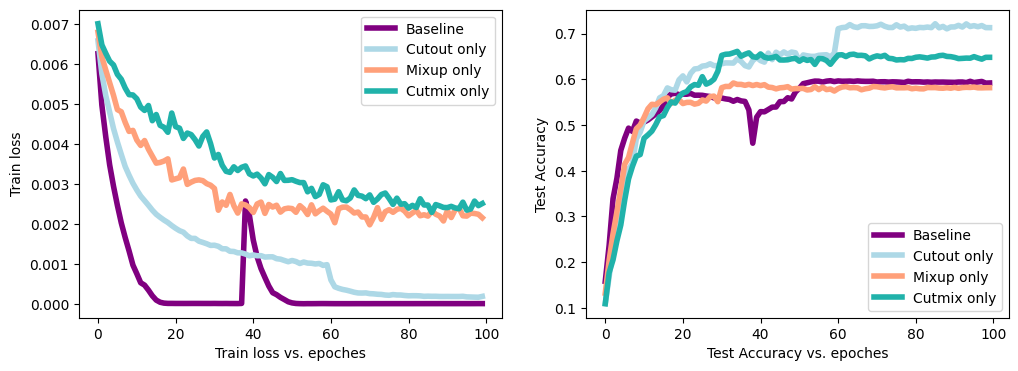

In [14]:
print("The best accuracy of %s is %.2f"%('Cutout',100*max(test_acc_cutoutonly))+'%')
print("The best accuracy of %s is %.2f"%('Mixup',100*max(test_acc_mixuponly))+'%')
print("The best accuracy of %s is %.2f"%('Cutmix',100*max(test_acc_cutmixonly))+'%')
x = range(100)
y1 = loss_baseline
y2 = loss_cutoutonly
y3 = loss_mixuponly
y4 = loss_cutmixonly
w1 = test_acc_baseline
w2 = test_acc_cutoutonly
w3 = test_acc_mixuponly
w4 = test_acc_cutmixonly
plt.subplot(1,2,1)
plt.plot(x,y1,color = 'purple',linewidth=4.0)
plt.plot(x,y2,color='lightblue',linewidth=4.0)
plt.plot(x,y3,color='lightsalmon',linewidth=4.0)
plt.plot(x,y4,color='lightseagreen',linewidth=4.0)
plt.xlabel('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.legend(['Baseline','Cutout only','Mixup only','Cutmix only'])
plt.subplot(1,2,2)
plt.plot(x,w1,color='purple',linewidth=4.0)
plt.plot(x,w2,color='lightblue',linewidth=4.0)
plt.plot(x,w3,color='lightsalmon',linewidth=4.0)
plt.plot(x,w4,color='lightseagreen',linewidth=4.0)
plt.xlabel('Test Accuracy vs. epoches')
plt.ylabel('Test Accuracy')
plt.legend(['Baseline','Cutout only','Mixup only','Cutmix only'])
plt.gcf().set_size_inches(12, 4)
plt.show()

### With Data Augumentation

The best accuracy of Cutout is 70.59%
The best accuracy of Mixup is 75.41%
The best accuracy of Cutmix is 71.74%


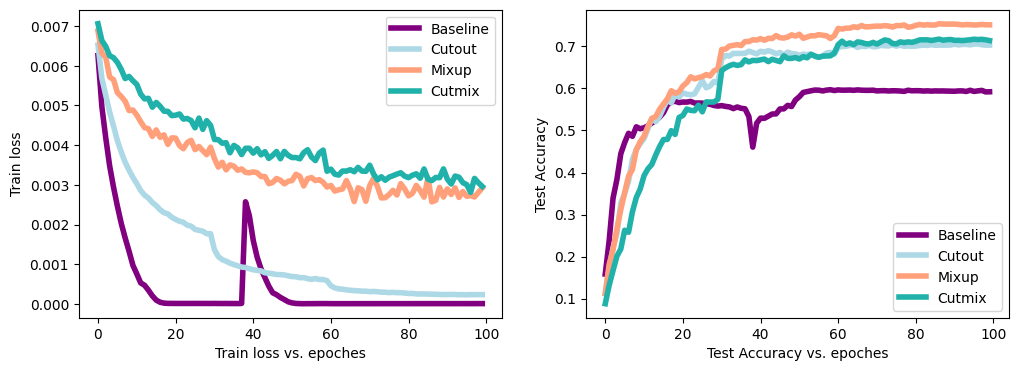

In [15]:
print("The best accuracy of %s is %.2f"%('Cutout',100*max(test_acc_cutout))+'%')
print("The best accuracy of %s is %.2f"%('Mixup',100*max(test_acc_mixup))+'%')
print("The best accuracy of %s is %.2f"%('Cutmix',100*max(test_acc_cutmix))+'%')
x = range(100)
y1 = loss_baseline
y2 = loss_cutout
y3 = loss_mixup
y4 = loss_cutmix
w1 = test_acc_baseline
w2 = test_acc_cutout
w3 = test_acc_mixup
w4 = test_acc_cutmix
plt.subplot(1,2,1)
plt.plot(x,y1,color = 'purple',linewidth=4.0)
plt.plot(x,y2,color='lightblue',linewidth=4.0)
plt.plot(x,y3,color='lightsalmon',linewidth=4.0)
plt.plot(x,y4,color='lightseagreen',linewidth=4.0)
plt.xlabel('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.legend(['Baseline','Cutout','Mixup','Cutmix'])
plt.subplot(1,2,2)
plt.plot(x,w1,color='purple',linewidth=4.0)
plt.plot(x,w2,color='lightblue',linewidth=4.0)
plt.plot(x,w3,color='lightsalmon',linewidth=4.0)
plt.plot(x,w4,color='lightseagreen',linewidth=4.0)
plt.xlabel('Test Accuracy vs. epoches')
plt.ylabel('Test Accuracy')
plt.legend(['Baseline','Cutout','Mixup','Cutmix'])
plt.gcf().set_size_inches(12, 4)
# plt.savefig('./fig/cmp_with_aug.png')
plt.show()

## Best Model

Mixup在augmentation基础上取得了最好的性能。我们进一步对model进行加深加宽，同时增加epoch轮数以及一些trick（具体设置见main.py），训练好之后将模型保存至models里

In [17]:
%run test.py --workers 16 --net_type Resnet --src ./models/baseline.pth

epoch: 1, test loss: 1.251726, test accuracy: 0.748300


In [18]:
%run test.py --workers 16 --net_type Resnet --src ./models/cutmix.pth

epoch: 1, test loss: 0.794706, test accuracy: 0.790900


In [19]:
%run test.py --workers 16 --net_type Resnet --src ./models/cutout.pth

epoch: 1, test loss: 0.921551, test accuracy: 0.772800


In [20]:
%run test.py --workers 16 --net_type Resnet --src ./models/mixup.pth

epoch: 1, test loss: 0.811717, test accuracy: 0.775200


可见，cutmix最终实现了79%的分类性能